# Tutorial sources

https://kearnz.github.io/autoimpute-tutorials/

https://github.com/ResidentMario/missingno

## Imports:

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, binom

In [2]:
# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [3]:
# data imputation libraries
import missingno as msno

## Some utilities and configurations

In [4]:
# seed to follow along
np.random.seed(0)

# Generating data (Missing Completely At Random MCAR)

In [5]:
# generate 1500 data points
N = np.arange(1500)

# helper function for this data
vary = lambda v: np.random.choice(np.arange(v))

# create correlated, random variables
a = 2
b = 1/2
eps = np.array([norm(0, vary(50)).rvs() for n in N])
y = (a + b*N + eps) / 100                         
x = (N + norm(10, vary(250)).rvs(len(N))) / 100

data = pd.DataFrame({"y": y, "x": x})

# 20% missing in x, 30% missing in y
x[binom(1, 0.2).rvs(len(N)) == 1] = np.nan
y[binom(1, 0.3).rvs(len(N)) == 1] = np.nan

# collect results in a dataframe 
data_miss = pd.DataFrame({"y": y, "x": x})

# Data Visualization

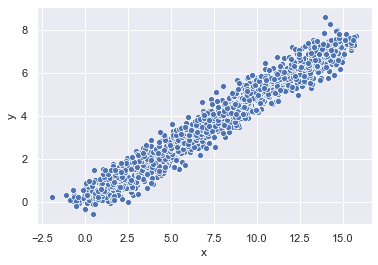

In [6]:
sns.scatterplot(x="x", y="y", data=data)

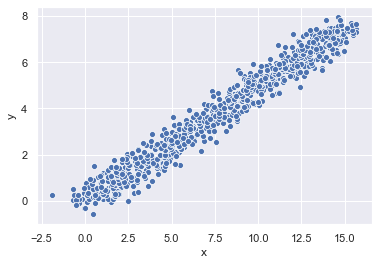

In [7]:
sns.scatterplot(x="x", y="y", data=data_miss)

# Missing values?

1. Using pandas directly (fast but somehow limited)
2. using imputation libraries (like missingno or autoimpute)

Note here that autoimpute uses missingno

In [8]:
data_miss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
y    1096 non-null float64
x    1155 non-null float64
dtypes: float64(2)
memory usage: 23.6 KB


In [9]:
print("Amount of data missing before imputation takes place")
pd.DataFrame(data_miss.isnull().sum(), columns=["records missing"]).T

Amount of data missing before imputation takes place


,y,x
records missing,404,345


### Visualisation with missingno

Note that autoimpute extends these functions

https://autoimpute.readthedocs.io/en/latest/user_guide/visuals.html

In [10]:
from autoimpute.visuals import plot_md_locations, plot_md_percent

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\siebert\.conda\envs\datapreparation\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


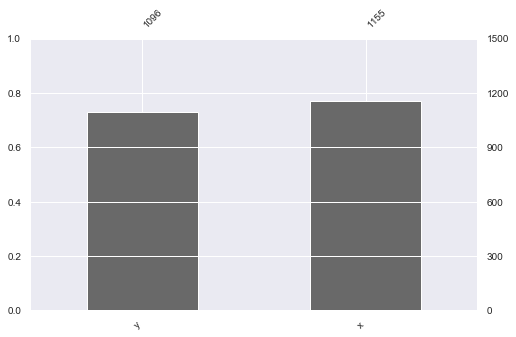

In [11]:
# plotplot_md_percent(data_miss)
msno.bar(data_miss, figsize=(8,5), fontsize=10)

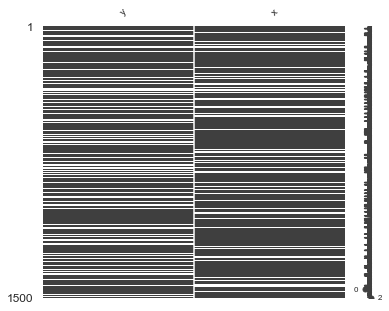

In [12]:
# plot_md_location(data_miss)
msno.matrix(data_miss, figsize=(6,5), fontsize=10)

# Correlation between missing values?

https://github.com/ResidentMario/missingno#heatmap

In [14]:
from autoimpute.visuals import plot_nullility_corr, plot_nullility_dendogram

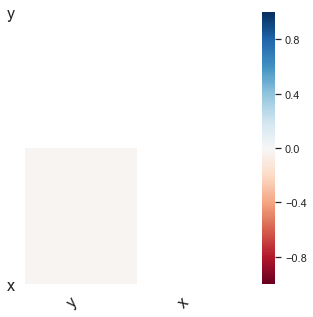

In [15]:
#plot_nullility_corr(data_miss, figsize=(5,5))
msno.heatmap(data_miss, figsize=(5,5))

# Impact of missing values on the analysis

In [16]:
from sklearn.linear_model import LinearRegression

# prep for regression
X = data_miss.x.values.reshape(-1, 1) # reshape because one feature only
y = data_miss.y
lm = LinearRegression()

# try to fit the model
print_header("Fitting linear model to estimate relationship between X and y")
try:
    lm.fit(X, y)
except ValueError as ve:
    print(f"{ve.__class__.__name__}: {ve}")

Fitting linear model to estimate relationship between X and y
-------------------------------------------------------------
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


# Deleting missing values (with pandas)

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html



## Example from 
https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87

<img src='https://miro.medium.com/max/2563/0*eX-2GHXoEEYn8LhX.png'>

In [17]:
data_miss.shape

(1500, 2)

In [18]:
# drop all rows that contains at least one missing value
data_miss.dropna(axis='index', how='any').shape

(838, 2)

In [19]:
# drop rows that only contains missing values
data_miss.dropna(axis='index', how='all').shape

(1413, 2)

In [20]:
# keep rows that have at least 2 non missing values
data_miss.dropna(axis='index', thresh=2).shape

(838, 2)

In [21]:
# keep columns that contains at least 600 non-missing value
data_miss.dropna(axis='columns', thresh=1100).shape

(1500, 1)

# Imputing values (Single Imputation)

Single imputation vs multiple imputations

In [22]:
from autoimpute.imputations import SingleImputer, MultipleImputer

### Imputation process with autoimpute

autoimpute follows the sklearn API guidelines

1. Create an Imputer object
2. Call fit() with train data
3. Call transform() to impute data

### Imputation strategy names

Strategies must be one of 
- 'default predictive', 
- 'least squares', 
- 'stochastic', 
- 'binary logistic', 
- 'multinomial logistic', 
- 'bayesian least squares', 
- 'bayesian binary logistic', 
- 'pmm', 
- 'lrd', 
- 'default univariate', 
- 'default time', 
- 'mean', 
- 'median', 
- 'mode', 
- 'random', 
- 'norm', 
- 'categorical', 
- 'interpolate', 
- 'locf', 
- 'nocb'

https://autoimpute.readthedocs.io/en/latest/user_guide/getting_started.html#imputation-methods-supported

In [24]:
# create the mean imputer
mean_imputer = SingleImputer(strategy='mean')

In [25]:
# fit the imputer with train dataset
mean_imputer.fit(data_miss)

SingleImputer(copy=True, imp_kwgs=None, predictors='all', seed=None,
              strategy='mean', visit='default')

In [26]:
# impute the data
data_imputed_once = mean_imputer.transform(data_miss)

### Some informations about the imputed data

In [27]:
# amount of missing data after imputation
print_header("Amount of data missing after imputation takes place")
pd.DataFrame(data_imputed_once.isnull().sum(), columns=["records missing"]).T

Amount of data missing after imputation takes place
---------------------------------------------------


,y,x
records missing,0,0


In [28]:
print_header("Showing the first 5 imputations for column x")
data_imputed_once.loc[mean_imputer.imputed_['x'], 'x'].head()

Showing the first 5 imputations for column x
--------------------------------------------


10    7.663901
14    7.663901
18    7.663901
35    7.663901
38    7.663901
Name: x, dtype: float64

In [29]:
data_miss['x'].mean()

7.663900890742314

### Visualizing the imputed data

https://autoimpute.readthedocs.io/en/latest/user_guide/visuals.html

In [30]:
from autoimpute.visuals import plot_imp_scatter

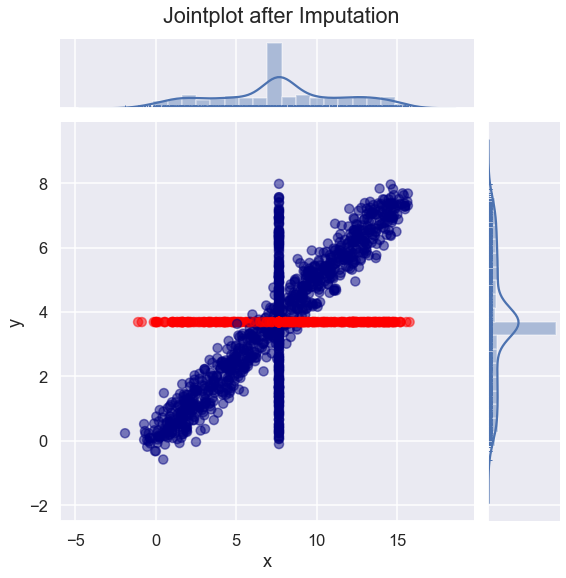

In [31]:
plot_imp_scatter(data_miss, 'x', 'y', strategy='mean')

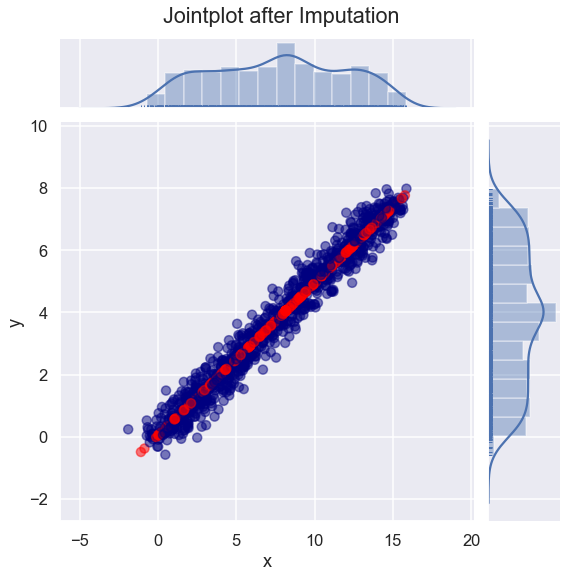

In [32]:
plot_imp_scatter(data_miss, 'x', 'y', strategy='least squares')

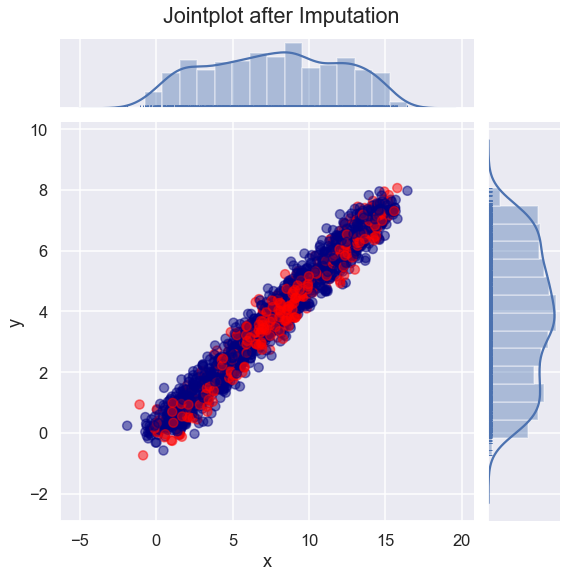

In [33]:
plot_imp_scatter(data_miss, 'x', 'y', strategy='stochastic')

# Comparing linear regressions, dropped missing values vs. imputed data vs original data

In [34]:
data_dropna                = data_miss.dropna()
data_imputed_mean          = SingleImputer(strategy='mean').fit_transform(data_miss)
data_imputed_least_squares = SingleImputer(strategy='least squares').fit_transform(data_miss)
data_imputed_stochastic    = SingleImputer(strategy='stochastic').fit_transform(data_miss)

In [35]:
def prepare_data(df):
    return {'X':df.x.values.reshape(-1, 1), 'y':df.y.values.reshape(-1, 1)}

In [36]:
from sklearn.linear_model import LinearRegression

# linear regressions with different data sets (TODO: train and test here) 
linreg_original              = LinearRegression().fit(**prepare_data(data))
linreg_dropna                = LinearRegression().fit(**prepare_data(data_dropna))
linreg_Imputed_mean          = LinearRegression().fit(**prepare_data(data_imputed_mean))
linreg_imputed_least_squares = LinearRegression().fit(**prepare_data(data_imputed_least_squares))
linreg_imputed_stochastic    = LinearRegression().fit(**prepare_data(data_imputed_stochastic))

In [41]:
scores = pd.DataFrame.from_records({
    'original':linreg_original.score(**prepare_data(data)),
    'dropna':linreg_dropna.score(**prepare_data(data_dropna)),
    'Imputed_mean':linreg_Imputed_mean.score(**prepare_data(data_imputed_mean)),
    'imputed_least_squares':linreg_imputed_least_squares.score(**prepare_data(data_imputed_least_squares)),
    'imputed_stochastic':linreg_imputed_stochastic.score(**prepare_data(data_imputed_stochastic)),
}, index=['R2 score'])
    

In [43]:
scores.T

,R2 score
Imputed_mean,0.557266
dropna,0.960973
imputed_least_squares,0.975634
imputed_stochastic,0.956471
original,0.959079
